In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report

In [2]:
df = pd.read_pickle("../data/data_prep.pkl")

In [3]:
df.head()

,date,team,opponent,score,elo,opponent_elo,home_match,result,match,last_result,last3_result,ewm_score,last_result_opponent,last3_result_opponent,ewm_score_opponent,last_result_diff,last3_result_diff,ewm_score_diff,elo_diff
0,1922-01-15,FRA,BEL,2,1300.0,1300.0,1,1,BEL-FRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,1922-01-15,BEL,FRA,1,1300.0,1300.0,0,-1,BEL-FRA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,1922-03-13,ENG,EUR,1,1300.0,1300.0,1,1,ENG-EUR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,1922-03-13,EUR,ENG,0,1300.0,1300.0,0,-1,ENG-EUR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,1922-03-26,BEL,NED,4,1295.0,1300.0,1,1,BEL-NED,-1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,-5.0


In [4]:
# df = df[df["tournament"].isin([
#     'FIFA World Cup',
#     'FIFA World Cup qualification',
#     #'Friendly',
#     'UEFA Euro',
#     'UEFA Euro qualification',
#     'UEFA Nations League',
# ])]

In [5]:
df = df.dropna()

In [6]:
df.head()

,date,team,opponent,score,elo,opponent_elo,home_match,result,match,last_result,last3_result,ewm_score,last_result_opponent,last3_result_opponent,ewm_score_opponent,last_result_diff,last3_result_diff,ewm_score_diff,elo_diff
28,1922-12-10,URU,ARG,1,1322.065,1257.005,1,1,ARG-URU,1.0,0.666667,0.730897,1.0,1.000000,1.490099,0.0,-0.333333,-0.759202,65.06
29,1922-12-10,ARG,URU,0,1257.005,1322.065,0,-1,ARG-URU,-1.0,-1.000000,0.269554,-1.0,-0.666667,0.000000,0.0,-0.333333,0.269554,-65.06
30,1922-12-17,ARG,URU,2,1254.970,1324.100,1,0,ARG-URU,-1.0,-1.000000,0.192173,-1.0,-1.000000,0.000000,0.0,0.000000,0.192173,-69.13
31,1922-12-17,URU,ARG,2,1324.100,1254.970,0,0,ARG-URU,1.0,1.000000,0.819554,1.0,1.000000,1.349405,0.0,0.000000,-0.529850,69.13
36,1923-02-04,BEL,ESP,1,1305.070,1314.860,1,1,BEL-ESP,1.0,0.666667,1.721535,-1.0,-1.000000,0.328904,2.0,1.666667,1.392631,-9.79


In [7]:
team_le = LabelEncoder()
opp_le = LabelEncoder()
match_le = LabelEncoder()

In [8]:
df["team_enc"] = team_le.fit_transform(df["team"])#.copy()
df["opponent_enc"] = opp_le.fit_transform(df["opponent"])
#df["match_enc"] = match_le.fit_transform(df["match"])

In [9]:
df["score"] = df["score"].clip(0,4)

In [10]:
train = df[df["date"].dt.year.between(1950, 2010)].copy()
test = df[df["date"].dt.year.between(2011, 2019)].copy()

In [11]:
len(train), len(test)

(5136, 1066)

# Result Model

In [12]:
model = GradientBoostingClassifier(n_estimators=200, random_state=123)

In [13]:
features = [c for c in df.columns if c not in ["date","team","opponent","match","result", "score", "result_classes"]]
features

['elo',
 'opponent_elo',
 'home_match',
 'last_result',
 'last3_result',
 'ewm_score',
 'last_result_opponent',
 'last3_result_opponent',
 'ewm_score_opponent',
 'last_result_diff',
 'last3_result_diff',
 'ewm_score_diff',
 'elo_diff',
 'team_enc',
 'opponent_enc']

In [14]:
#train[features]

In [15]:
target = "result"
#target = "result_classes" # classes like 1:0, 2:1, ...

In [16]:
model.fit(train[features], 
          train[target]
         )

GradientBoostingClassifier(n_estimators=200, random_state=123)

In [17]:
test[f"{target}_pred"] = model.predict(test[features])

In [18]:
accuracy_score(test[target], test[f"{target}_pred"])

0.49906191369606

In [19]:
#train["result_pred"] = model.predict(train[features])

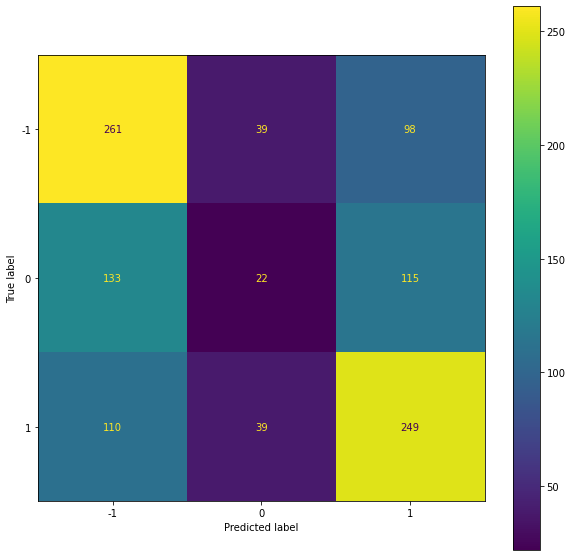

In [20]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(model, test[features], test[f"{target}"], ax=ax)

<BarContainer object of 15 artists>

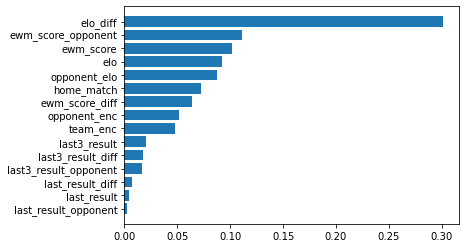

In [21]:
data={'feature_names':np.array(train[features].columns),
      'feature_importance':np.array(model.feature_importances_)}
fi_df = pd.DataFrame(data).sort_values(["feature_importance"], ascending=True)
plt.barh(fi_df["feature_names"].values, fi_df["feature_importance"].values)

# Goal model

In [22]:
features = [c for c in train.columns if c not in ["date","team","opponent","match","result", "score", "result_classes"]]

In [23]:
goal_model = GradientBoostingClassifier(n_estimators=100, random_state=123)

In [24]:
#train[features]

In [25]:
goal_model.fit(train[features], 
               train["score"]
              )

GradientBoostingClassifier(random_state=123)

In [26]:
test["score_pred"] = goal_model.predict(test[features])

In [27]:
accuracy_score(test["score"], test["score_pred"])

0.3330206378986867

In [28]:
test.head(2)

,date,team,opponent,score,elo,opponent_elo,home_match,result,match,last_result,...,last3_result_opponent,ewm_score_opponent,last_result_diff,last3_result_diff,ewm_score_diff,elo_diff,team_enc,opponent_enc,result_pred,score_pred
6160,2011-01-17,KSA,JPN,0,1216.755,1312.475,0,-1,JPN-KSA,0.0,...,-0.333333,1.164841,1.0,0.0,0.015525,-95.72,18,17,-1,1
6161,2011-01-17,JPN,KSA,4,1312.475,1216.755,1,1,JPN-KSA,1.0,...,0.333333,1.095458,1.0,0.0,0.356740,95.72,17,18,1,1


In [29]:
test_pivot = pd.pivot_table(test, index=["date","match"], 
                            values=["score_pred"], columns=["home_match"], 
                            aggfunc="sum").reset_index()

In [30]:
test_pivot.columns = [c[0]+str(c[1]) for c in test_pivot.columns]

In [31]:
test_pivot

,date,match,score_pred0,score_pred1
0,2011-01-17,JPN-KSA,1,1
1,2011-01-21,JPN-QAT,2,1
2,2011-02-09,ARG-POR,1,1
3,2011-02-09,BRA-FRA,1,1
4,2011-02-09,DEN-ENG,1,1
...,...,...,...,...
528,2019-10-15,CAN-USA,2,0
529,2019-10-15,ICP-1-URU,0,1
530,2019-11-15,CAN-USA,0,2
531,2019-11-18,ARG-URU,1,1


In [32]:
test_pivot["results_pred"] = np.where(test_pivot['score_pred1'] > test_pivot['score_pred0'], 1, 
         np.where(test_pivot['score_pred1'] < test_pivot['score_pred0'], -1, 0)
        )

In [33]:
test.head()

,date,team,opponent,score,elo,opponent_elo,home_match,result,match,last_result,...,last3_result_opponent,ewm_score_opponent,last_result_diff,last3_result_diff,ewm_score_diff,elo_diff,team_enc,opponent_enc,result_pred,score_pred
6160,2011-01-17,KSA,JPN,0,1216.755,1312.475,0,-1,JPN-KSA,0.0,...,-0.333333,1.164841,1.0,0.000000,0.015525,-95.72,18,17,-1,1
6161,2011-01-17,JPN,KSA,4,1312.475,1216.755,1,1,JPN-KSA,1.0,...,0.333333,1.095458,1.0,0.000000,0.356740,95.72,17,18,1,1
6162,2011-01-21,QAT,JPN,2,1191.545,1327.115,1,-1,JPN-QAT,0.0,...,-1.000000,0.953052,1.0,1.000000,0.214783,-135.57,24,17,0,1
6163,2011-01-21,JPN,QAT,3,1327.115,1191.545,0,1,JPN-QAT,1.0,...,0.000000,1.685557,1.0,1.000000,0.411696,135.57,17,24,1,2
6164,2011-02-09,ARG,POR,2,1438.260,1366.230,0,1,ARG-POR,1.0,...,-0.333333,1.209367,2.0,0.666667,0.415673,72.03,0,23,1,1


In [34]:
test = test.merge(test_pivot[["date","match","results_pred"]], on=["date","match"])

In [35]:
accuracy_score(test["result"], test["results_pred"])

0.32926829268292684

<BarContainer object of 15 artists>

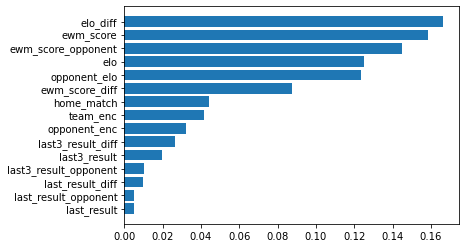

In [36]:
data={'feature_names':np.array(train[features].columns),
      'feature_importance':np.array(goal_model.feature_importances_)}
fi_df = pd.DataFrame(data).sort_values(["feature_importance"], ascending=True)
plt.barh(fi_df["feature_names"].values, fi_df["feature_importance"].values)